### Imports and setup

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [129]:
df = pd.read_csv("~/pings/ping_data/google_2024-01-20.csv", header=0, 
                 names=['time', 'latency_raw'], 
                 parse_dates=['time'],  # Specifying the column to parse as datetime
                 dtype={'latency_raw': object})  # Setting the data type for the 'latency_raw' column


In [130]:
# Capture a new column that has no strings, NaN's where we see strings (errors, or time outs)
df['latency_float'] = pd.to_numeric(df['latency_raw'], errors='coerce')

In [131]:
df.head(5)

,time,latency_raw,latency_float
0,2024-01-20 18:46:08,13.2,13.2
1,2024-01-20 18:46:09,28.9,28.9
2,2024-01-20 18:46:10,14.7,14.7
3,2024-01-20 18:46:12,18.3,18.3
4,2024-01-20 18:46:13,22.7,22.7


### Analysis

In [132]:
# Count nan's in the latency column
drops = df['latency_float'].isnull().sum()

# What's the percentage of ping drops?
drop_rate = drops/len(df)

print(f'There were {drops} drops out of {len(df)} pings, or {drop_rate*100:.3g}% drop rate.')

There were 6 drops out of 18068 pings, or 0.0332% drop rate.


In [133]:
# Let's drop the nan's and do some base analytics on the successful pings.
pings_list = df['latency_float'].apply(pd.to_numeric, errors='coerce')
print(pings_list.describe())

count    18062.000000
mean        33.734325
std        118.257527
min          9.020000
25%         16.200000
50%         20.600000
75%         27.200000
max       3742.000000
Name: latency_float, dtype: float64


In [134]:
# What do the "NaN's" look like?
nans_df = df[df['latency_float'].isnull()]
nans_df['latency_raw'].value_counts()

PING www.google.com (142.251.116.105) 56(84) bytes of data.\n\n--- www.google.com ping statistics ---\n1 packets transmitted, 0 received, 100% packet loss, time 0ms\n\n    3
PING www.google.com (142.251.116.99) 56(84) bytes of data.\n\n--- www.google.com ping statistics ---\n1 packets transmitted, 0 received, 100% packet loss, time 0ms\n\n     1
PING www.google.com (142.250.114.105) 56(84) bytes of data.\n\n--- www.google.com ping statistics ---\n1 packets transmitted, 0 received, 100% packet loss, time 0ms\n\n    1
PING www.google.com (142.251.116.147) 56(84) bytes of data.\n\n--- www.google.com ping statistics ---\n1 packets transmitted, 0 received, 100% packet loss, time 0ms\n\n    1
Name: latency_raw, dtype: int64

### Visualizations

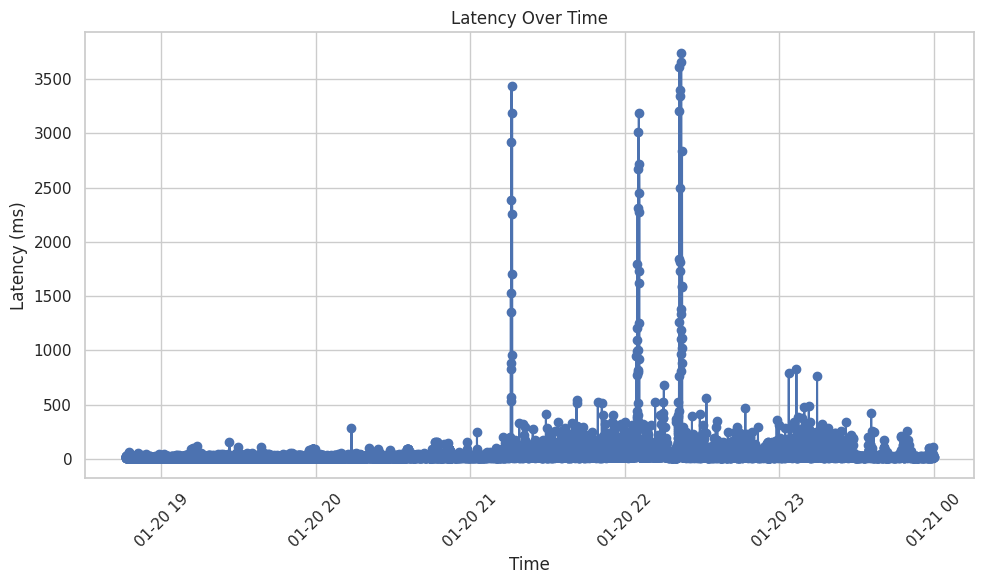

In [135]:
# Set the plot style for better aesthetics
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))  # You can adjust the size as per your requirement
plt.plot(df['time'], df['latency_float'], marker='o')  # 'o' adds markers to each data point

# Customize the plot
plt.title('Latency Over Time')
plt.xlabel('Time')
plt.ylabel('Latency (ms)')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping

# Display the plot
plt.show()

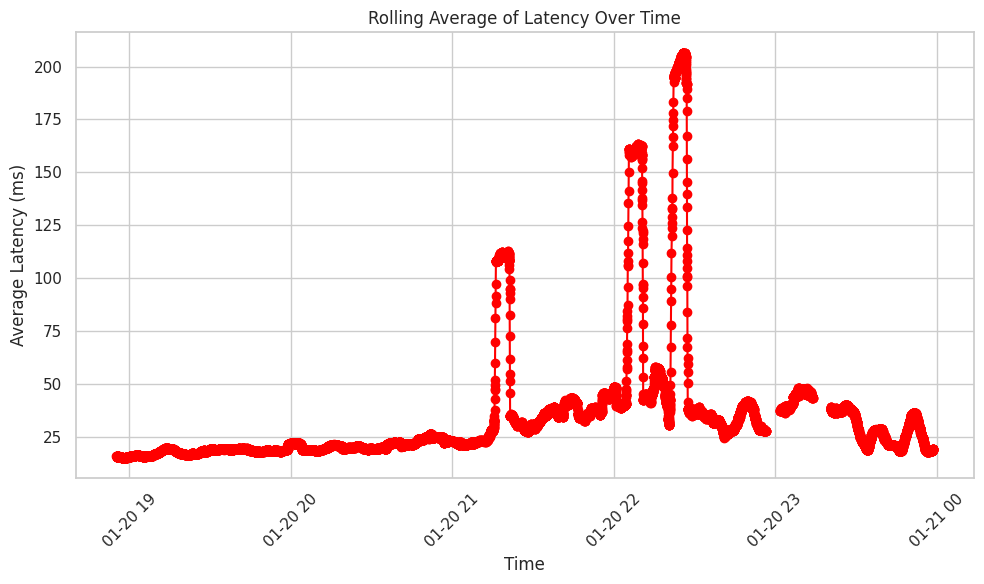

In [136]:
# Calculate the rolling average
window_size = 300  # Adjust this as needed
df['rolling_avg_latency'] = df['latency_float'].rolling(window=window_size).mean()

# Set the plot style for better aesthetics
sns.set(style="whitegrid")

# Create the plot for rolling average
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['rolling_avg_latency'], color='red', marker='o')

# Customize the plot
plt.title('Rolling Average of Latency Over Time')
plt.xlabel('Time')
plt.ylabel('Average Latency (ms)')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

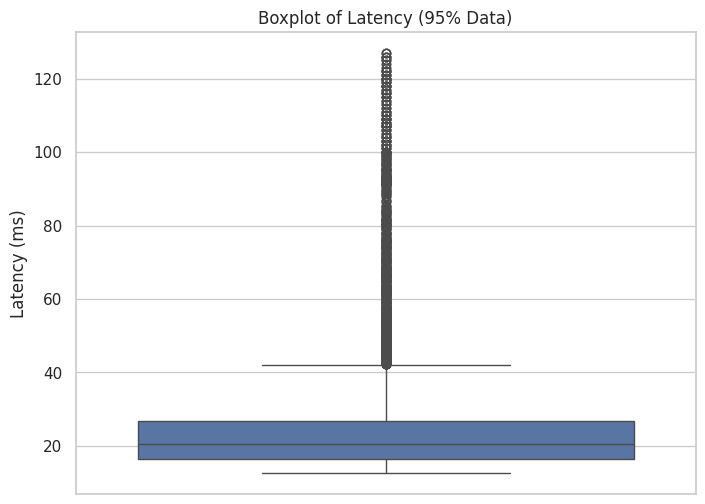

In [137]:
# Calculate the 2.5th and 97.5th percentiles
lower_percentile = df['latency_float'].quantile(0.025)
upper_percentile = df['latency_float'].quantile(0.975)

# Filter out data outside these percentiles
filtered_df = df[(df['latency_float'] >= lower_percentile) & (df['latency_float'] <= upper_percentile)]

# Set the plot style for better aesthetics
sns.set(style="whitegrid")

# Create the boxplot with filtered data
plt.figure(figsize=(8, 6))
sns.boxplot(y=filtered_df['latency_float'])

# Customize the plot
plt.title('Boxplot of Latency (95% Data)')
plt.ylabel('Latency (ms)')

# Display the plot
plt.show()

### Anomaly Detection
How many anomalies am I seeing per day? per hour?

How do we define an anomaly?

In [138]:
# Q: What is the "hello world" of Anomaly Detection?

Anomaly counts by hour:
hour
2024-01-20 18:00:00     55
2024-01-20 19:00:00    148
2024-01-20 20:00:00    145
2024-01-20 21:00:00    433
2024-01-20 22:00:00    620
2024-01-20 23:00:00    404
dtype: int64


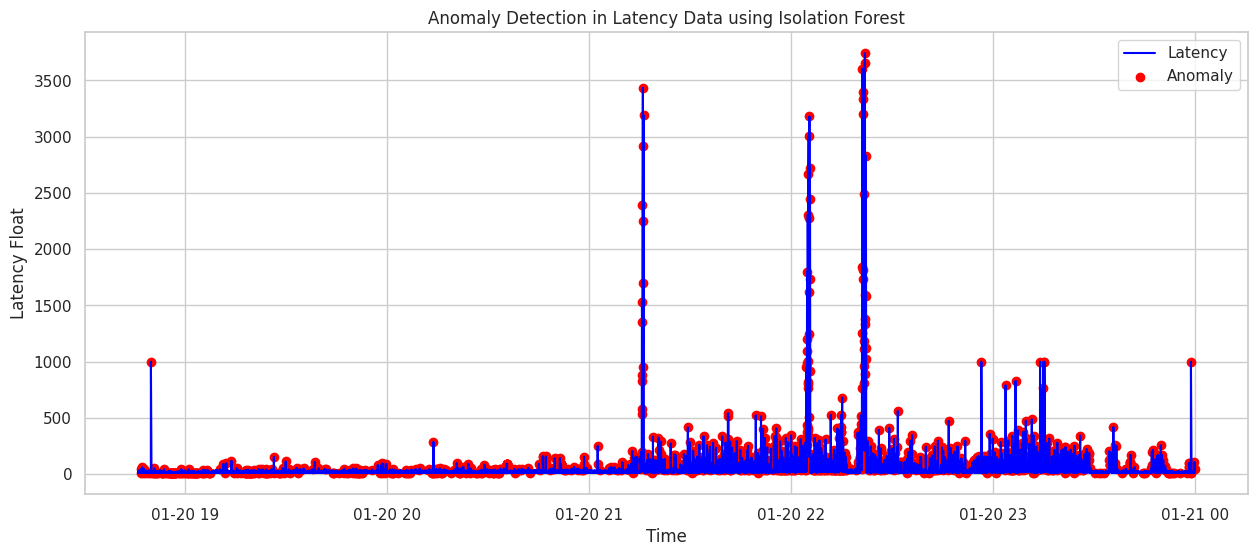

In [141]:
from sklearn.ensemble import IsolationForest

df['latency_nonulls'] = df['latency_float'].fillna(1000) # Handling NaNs, technically if we have a NaN we had a 1k ms ping.

# Adjusting the contamination factor
contamination_factor = 0.01 # Default is 0.1, but may be a bit too sensitive for our use-case.
clf = IsolationForest(n_estimators=100, contamination=contamination_factor, random_state=42)
df['anomaly'] = clf.fit_predict(df[['latency_nonulls']].values.reshape(-1, 1))

# Counting anomalies per hour
df['hour'] = df['time'].dt.floor('H')  # Create a new column to represent the hour
anomaly_counts = df[df['anomaly'] == -1].groupby('hour').size()
print(f"Anomaly counts by hour:\n{anomaly_counts}")

# Plotting the results
plt.figure(figsize=(15, 6))
plt.plot(df['time'], df['latency_nonulls'], color='blue', label='Latency')
anomalies = df[df['anomaly'] == -1]
plt.scatter(anomalies['time'], anomalies['latency_nonulls'], color='red', label='Anomaly')
plt.title('Anomaly Detection in Latency Data using Isolation Forest')
plt.xlabel('Time')
plt.ylabel('Latency Float')
plt.legend()
plt.show()